# Tree decomposition, treewidth, and other stories

In [257]:
import networkx as nx

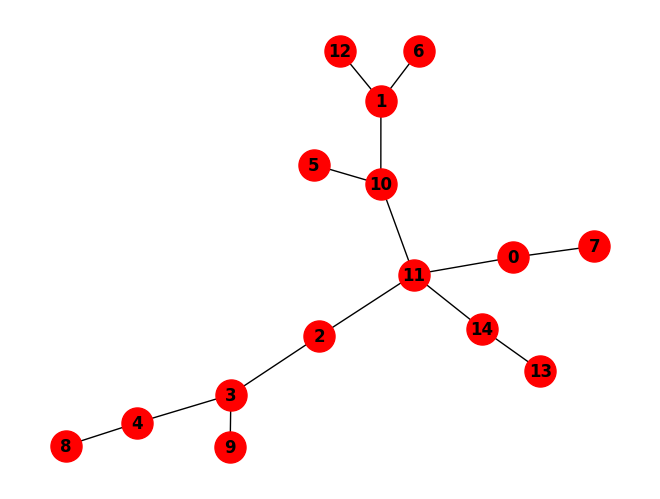

In [258]:
Tree:nx.classes.graph = nx.generators.random_tree(15, seed = 42)
nx.draw(Tree, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

# Maximum Independent Set on Trees
Maximum independent set is a classical NP-Complete problem.
NP-Complete problems are usually difficult to solve and require extensive computation. On trees, many NP-Complete problems can be solved efficiently and in an exact way in linear time, using dynamic programming.

> **Definition (Independent set)**: Let $G = (V, E)$, an independent set $IS(G)$ is a set of nodes $C \subset V$ such that no edges exist between these nodes.
>
> Formally: $$ IS(G) = \left\{ C \subset V:\quad \forall u, v \in C\; \nexists (u,v) \in E\right\}$$
 
Let's implement a function to compute the maximum independent set on a tree using dynamic programming. We define two tables $M^+[v]$, where we store the size of the largest independent set in $v$'s subtree, including the node $v$ and $M^-[v]$, where we store the size of the largest independent set in $v$'s subtree excluding the node v. With this wto tables we can solve the MIS on a tree in linear time as follows. we root the tree on a random node and we visit the nodes of the tree in postorder (dfs). For each node with children $w_1, \dots ,w_d$ we compute the following:

$$ 
 M^+[v] = 1 + \sum_{i=0}^{i=d} M^-[w_i]\\
 M^-[v] = \sum_{i=0}^{i=d} \max{\left(M^+[w_i], M^-[w_i]\right)}
$$

NetworkX offers two useful functions here: 
- bfs\_successors: which takes a tree and a root node and returns the successors of each node
- dfs\_postorder\_nodes: which, given a tree and a root node, returns the the nodes of the tree in postorder

We compute the MIS on the tree we plotted above.

In [259]:
from networkx import dfs_postorder_nodes, bfs_successors

def MIS_on_tree(tree:nx.classes.graph.Graph):

    M_plus = {key:0 for key in tree.nodes}
    M_minus = {key:0 for key in tree.nodes}
    
    root = list(tree.nodes)[0]
    
    print(root)

    postorder = dfs_postorder_nodes(tree, root)
    
    def dfs(node: int):
        children:list = list(bfs_successors(tree, source=node, depth_limit=1))[0][1]

        
        print(f"Figli di {node}: {list(children)}")
        #Caso base
        if (bfs_successors(tree, node) == 0):
            M_plus[node] = 1
            M_minus[node] = 0
            return

        #Per ogni figlio del nodo
        M_plus[node] = 1 + sum(M_minus[child] for child in children)
        M_minus[node] = sum(max(M_plus[child], M_minus[child]) for child in children)

        print(f"M_plus per {node}: {M_plus[node]}")
        print(f"M_minus per {node}: {M_minus[node]}")

    #Post order
    for node in postorder:
        dfs(node)

    #Calcolo su MIS sul tree
    MIS = max(M_plus[root], M_minus[root])

    return MIS 

In [260]:
MIS_on_tree(Tree)

0
Figli di 7: [0]
M_plus per 7: 1
M_minus per 7: 0
Figli di 8: [4]
M_plus per 8: 1
M_minus per 8: 0
Figli di 4: [8, 3]
M_plus per 4: 1
M_minus per 4: 1
Figli di 9: [3]
M_plus per 9: 1
M_minus per 9: 0
Figli di 3: [4, 9, 2]
M_plus per 3: 2
M_minus per 3: 2
Figli di 2: [3, 11]
M_plus per 2: 3
M_minus per 2: 2
Figli di 5: [10]
M_plus per 5: 1
M_minus per 5: 0
Figli di 6: [1]
M_plus per 6: 1
M_minus per 6: 0
Figli di 12: [1]
M_plus per 12: 1
M_minus per 12: 0
Figli di 1: [6, 12, 10]
M_plus per 1: 1
M_minus per 1: 2
Figli di 10: [5, 1, 11]
M_plus per 10: 3
M_minus per 10: 3
Figli di 13: [14]
M_plus per 13: 1
M_minus per 13: 0
Figli di 14: [11, 13]
M_plus per 14: 1
M_minus per 14: 1
Figli di 11: [0, 2, 10, 14]
M_plus per 11: 7
M_minus per 11: 7
Figli di 0: [7, 11]
M_plus per 0: 8
M_minus per 0: 8


8

# Tree Decomposition of Graphs

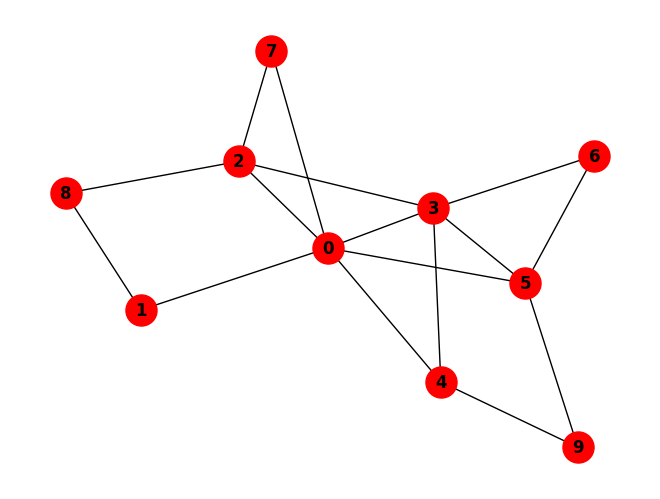

In [261]:
G = nx.Graph(
    [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (1, 8), (2, 3),
     (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (4, 9), (5, 6), (5, 9)]
)
pos = pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

Let's compute the tree decomposition with the minimum degree heuristic

In [262]:
w, T = nx.approximation.treewidth_min_degree(G) # Yes! NetworkX offers an implementation of the algorithm you have seen today!
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


Let's plot the tree decomposition

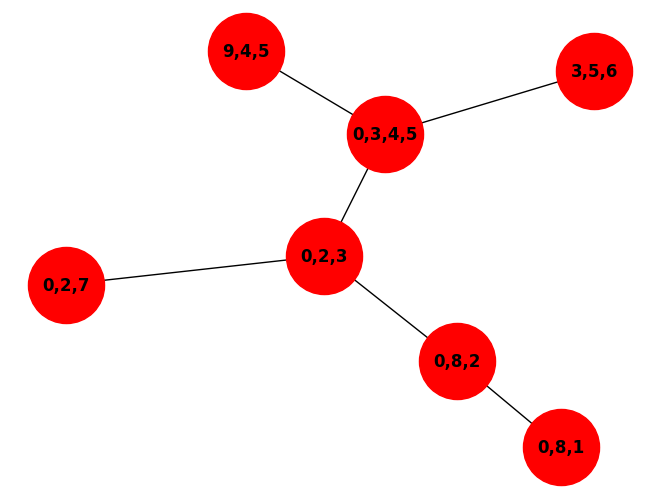

In [263]:
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

Let's implement a function to perform a tree decomposition of a graph. We assume first that the elimination order is given. Later on we will focus on the minimum degree heuristic.
Given an elimination order, we need to remove each node from a graph, make a bag with the node we have just removed and its neighbours, and triangulate the neighbours in the graph (that is, we connect all the neighbours of the node we have removed with each other).
If the bag is already a subset of an existing bag, we discard it.
When we have removed all the nodes, we connect each bag with the bag for which the intersection of the nodes contained in the bags is the maximum.

In [264]:

from networkx import neighbors

def tree_decomposition(G:nx.graph.Graph, elimination_order, verbose = False):
    # your code here!
    if verbose: print(f"Ordine di eliminazione: {elimination_order}")

    bags:list[set] = []
    #Per ogni nodo di elimination_order
    for node in elimination_order:
        is_sub_set = False

        #Prendiamo i vicini del nodo
        neig = set(list(neighbors(G, node)))
        if verbose: print(f"Vicini di {node}: {neig}")

        #Formiamo una bag
        neig.add(node)
        if verbose: print(f"Bag fatta: {neig}")

        #Controlliamo che la bag non sia subset di un'altra bag
        for bag in bags:
            #Se una bag contiene già neig, non aggiungiamo
            if bag.issuperset(neig):
                if verbose: print(f"Bag {bag} è un superset di {neig}")
                is_sub_set = True
        
        #Se la bag non è subset, aggiungiamo 
        if not is_sub_set:
            bags.append(neig)

        #Rimuoviamo il nodo dal grafo
        G.remove_node(node)
        if verbose: print(f"Le bags: {bags}")

        #Rimuovere il nodo dai neig, facendo attenzione a non cambiare l'oggetto dentro la lista
        neig_without_node = neig.copy()
        neig_without_node.remove(node)
        

        #Colleghiamo ogni vicino con ogni altro vicino
        collegaVicini(G, neig_without_node)

    if verbose: print(f"Le bags sono : {bags}")

    tuples = []
    #Per ogni bag
    for b in bags:
        #Controlliamo le altre bags
        #Colleghiamo la bag con la quale c'è il maggior numero di intersezioni
        maximalIntersection = set()
        tuple = set()
        for b1 in bags:
            if len(b.intersection(b1)) > len(maximalIntersection) and b != b1:
                maximalIntersection = b.intersection(b1)
                tuple = (b,b1)
        
        tuples.append(tuple)
        
    if verbose: print(tuples)

    #Prendere w come la lunghezza massima delle tuple
    w = max(len(b) for b in bags)
    if verbose: print(w)

    #Creare un che contiene le bags come nodi e le tuple come archi
    T = nx.Graph()

    #Per ogni tupla
    for t in tuples:
        #Aggiungiamo gli archi
        #Sapendo che una tupla e' formata da 
        #({2, 3}, {3, 4, 5})
        #Vogliamo avere ((2,3), (3,4,5))
        #prendiamo le stringhe delle bags e le usiamo come nodi
        #Aggiungiamo gli archi
        T.add_edge(str(t[0]), str(t[1]))

    return w, T
    


def collegaVicini(G:nx.graph.Graph, vicini:list):
    for n1 in vicini:
        for n2 in vicini:
            if n1 != n2 and not G.has_edge(n1,n2):
                G.add_edge(n1,n2)

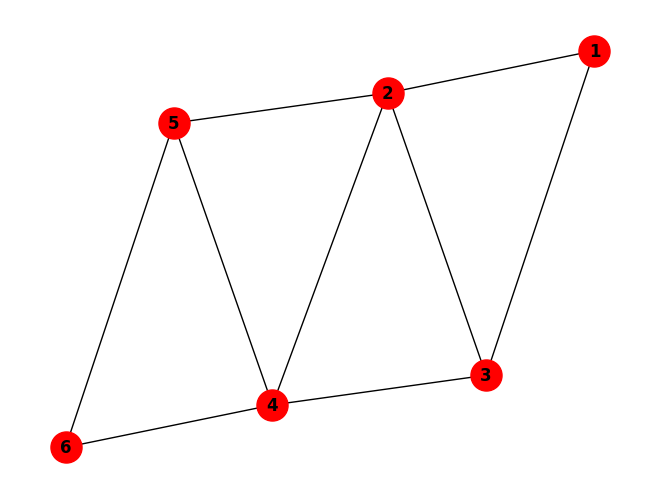

In [265]:
G2 = nx.Graph(
    [(1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (2, 5), (4, 5), (5, 6), (4, 6)]
)
pos = pos = nx.spring_layout(G2)
nx.draw(G2, pos=pos, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

Consider this graph and obtain a tree decomposition

In [266]:
# It should print "The graph G has t
# reewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph."
w, T = tree_decomposition(G2, [1,2,3,4,5,6])
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 4; as such, 5 cops are sufficient to catch a robber in this graph.


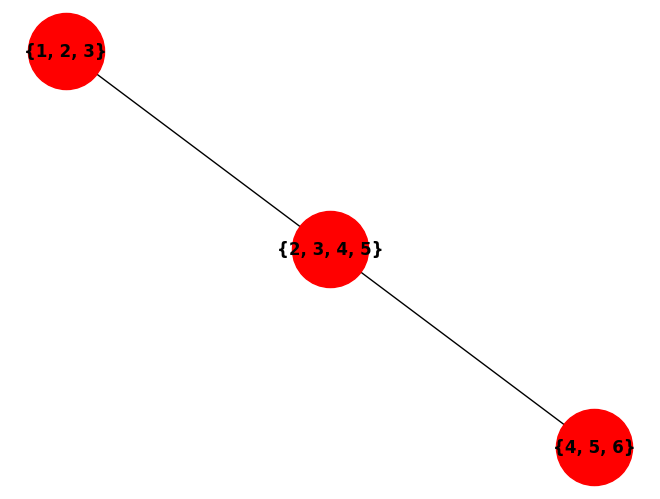

In [267]:
# It should plot a line tree with three bags, two of which contain 3 nodes and one contains 4 nodes.
labels = {node:''.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

Let's consider a different node removal order

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


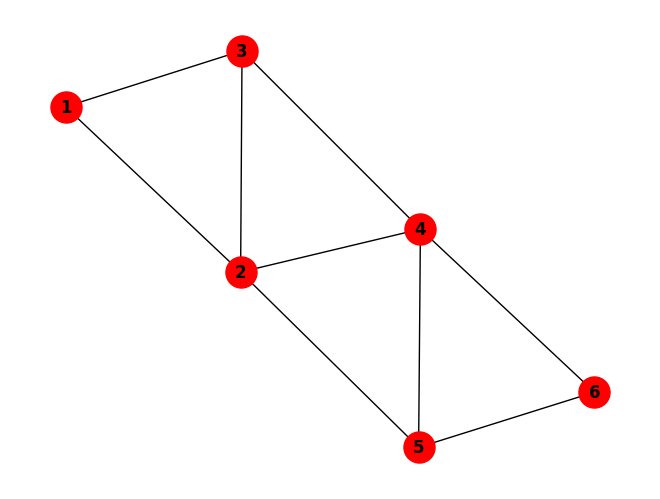

In [268]:

G2 = nx.Graph(
    [(1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (2, 5), (4, 5), (5, 6), (4, 6)]
)
pos = pos = nx.spring_layout(G2)
nx.draw(G2, pos=pos, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

# It should print "The graph G has treewidth at most 2; as such, 3 cops are sufficient to catch a robber in this graph."
w, T = tree_decomposition(G2, [1,3,2,4,5,6])
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

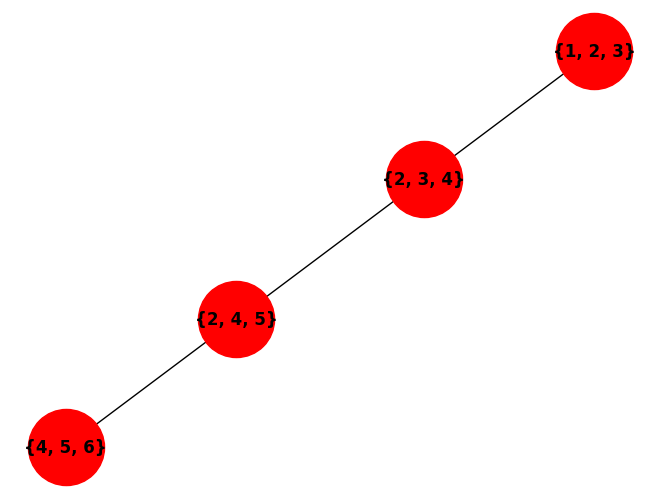

In [269]:
# It should plot a line tree with four bags, each containing 3 nodes
labels = {node:''.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

This shows that the elimination order matters. So, now, let's implement the minimum degree heuristic to obtain a good elimination order.

## Definizione (Minimum degree heuristic)

Quando rimuoviamo un nodo
dalla tree decomposition, rimuoviamo il nodo che ha il **grado minore**, cio´e il
nodo che ha il **minor numero di vicini**.

Rimuovere un nodo cambia anche il grado dei vicini e quindi calcoliamo il
minimum degree ad ogni iterazione.

$$
\begin{align}
\text{Removal Order} \\
\text{While } G \neq \emptyset \\
\quad v \leftarrow \text{argmin}_{v \in V} \text{deg}(v) \\
\quad G \leftarrow G \setminus \{v\} \\
\quad \text{Update degree of neighbours of } v \\
\end{align}
$$


In [270]:
def min_degree_elimination_order(G:nx.graph.Graph):
    # Your code here
    order = []

    #Copiamo il grafo perchè non vogliamo modificarlo
    G_copy = G.copy()

    #fino a quando i nodi non sono vuoti
    while(len(G_copy.nodes())):
        degrees = {node:G_copy.degree(node) for node in G_copy.nodes() }
        val = min(degrees, key=degrees.get)
        print(f"Chiave: {val} - Valore: {degrees[val]}")
        order.append(val)
        G_copy.remove_node(val)
    
    print(order)
    return order

Let's consider again the first graph G. Let's now compute the tree decomposition with the minimum degree heuristic.

In [271]:
G = nx.Graph(
    [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (1, 8), (2, 3),
     (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (4, 9), (5, 6), (5, 9)]
)

In [272]:
w, T = tree_decomposition(G,
 min_degree_elimination_order(G))
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

Chiave: 1 - Valore: 2
Chiave: 8 - Valore: 1
Chiave: 7 - Valore: 2
Chiave: 2 - Valore: 2
Chiave: 6 - Valore: 2
Chiave: 9 - Valore: 2
Chiave: 4 - Valore: 2
Chiave: 0 - Valore: 2
Chiave: 3 - Valore: 1
Chiave: 5 - Valore: 0
[1, 8, 7, 2, 6, 9, 4, 0, 3, 5]
The graph G has treewidth at most 4; as such, 5 cops are sufficient to catch a robber in this graph.


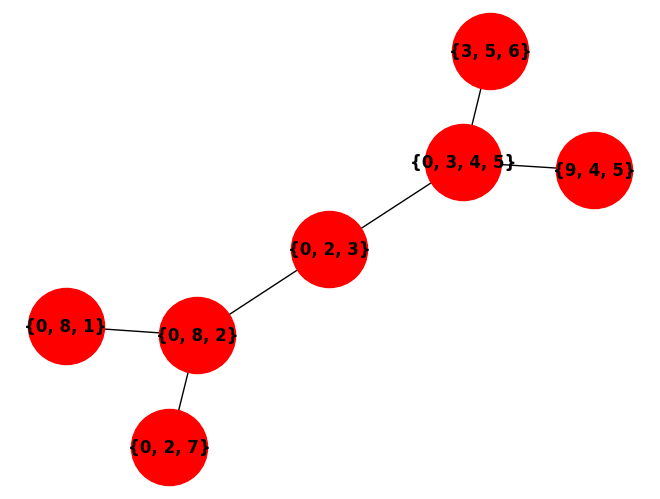

In [273]:
# This should plot a tree decomposition equivalent to the one obtained by the NetworkX function
labels = {node:''.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)